In [ ]:
# default_exp models


# models
> models to be used in contextual map solvers

In [ ]:
#export
from thompson_sampling.multi_armed_bandits import contextual_categorical_bandit, contextual_categorical_get_optimal_arm, contextual_numerical_bandit
import matplotlib.pyplot as plt
import numpy as np




Bad key "text.kerning_factor" on line 4 in
/home/thomas/anaconda3/envs/pytorch_GPU/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
theta = [0.6, 0.9]
noise = 0.1

np.random.seed(42)

## Categorical
> for logistic regression

### Linear

In [ ]:
#export
from scipy.optimize import minimize
import scipy.stats as stats
import numpy as np



class OnlineLogisticRegression:
    """taken from https://gdmarmerola.github.io/ts-for-contextual-bandits/ """
    
    # initializing
    def __init__(self,n_dim, lambda_ = None, alpha = None):
        
        # the only hyperparameter is the deviation on the prior (L2 regularizer)
        self.lambda_ = lambda_ or 1
        self.alpha = alpha or 1
                
        # initializing parameters of the model
        self.n_dim = n_dim, 
        self.m = np.zeros(self.n_dim)
        self.q = np.ones(self.n_dim) * self.lambda_
        
        # initializing weights
        self.w = np.random.normal(self.m, self.alpha * (self.q)**(-1.0), size = self.n_dim)
        
    # the loss function
    def loss(self, w, *args):
        X, y = args
        return 0.5 * (self.q * (w - self.m)).dot(w - self.m) + np.sum([np.log(1 + np.exp(-y[j] * w.dot(X[j]))) for j in range(y.shape[0])])
        
    # the gradient
    def grad(self, w, *args):
        X, y = args
        return self.q * (w - self.m) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis=0)
    
    # method for sampling weights
    def get_weights(self):
      return stats.multivariate_normal(self.m, self.alpha * (self.q)**(-1.0)).rvs()
        #return np.random.normal(self.m, self.alpha * (self.q)**(-1.0), size = self.n_dim)
    
    # fitting method
    def fit(self, X, y):
        
#         print(X)
        
#         print(f'X {X.shape}')
#         print(f'y {y.shape}')
#         print(f'self w {self.w.shape}')
#         print(f'self m {self.m.shape}')
                
        # step 1, find w
        self.w = minimize(self.loss, self.w, args=(X, y), jac=self.grad, method="L-BFGS-B", options={'maxiter': 20, 'disp':True}).x
        self.m = self.w
        
        # step 2, update q
        P = (1 + np.exp(1 - X.dot(self.m))) ** (-1)
        self.q = self.q + (P*(1-P)).dot(X ** 2)


    def observe(self,X,y):
        self.fit(X,y)
                
    # probability output method, using weights sample
    def predict_proba(self, X, mode='sample'):
        
        # adding intercept to X
        #X = add_constant(X)
        
        # sampling weights after update
        self.w = self.get_weights()
        
        # using weight depending on mode
        if mode == 'sample':
            w = self.w # weights are samples of posteriors
        elif mode == 'expected':
            w = self.m # weights are expected values of posteriors
        else:
            raise Exception('mode not recognized!')
            
            
        X = np.atleast_1d(X)
        w = np.atleast_1d(w)
        #print(f'X shape {X.shape}')
        #print(f'w shape {w.shape}')

        # calculating probabilities
        proba = 1 / (1 + np.exp(-1 * X.dot(w)))
        return np.array([1-proba , proba]).T

No handles with labels found to put in legend.


<Figure size 1350x525 with 0 Axes>

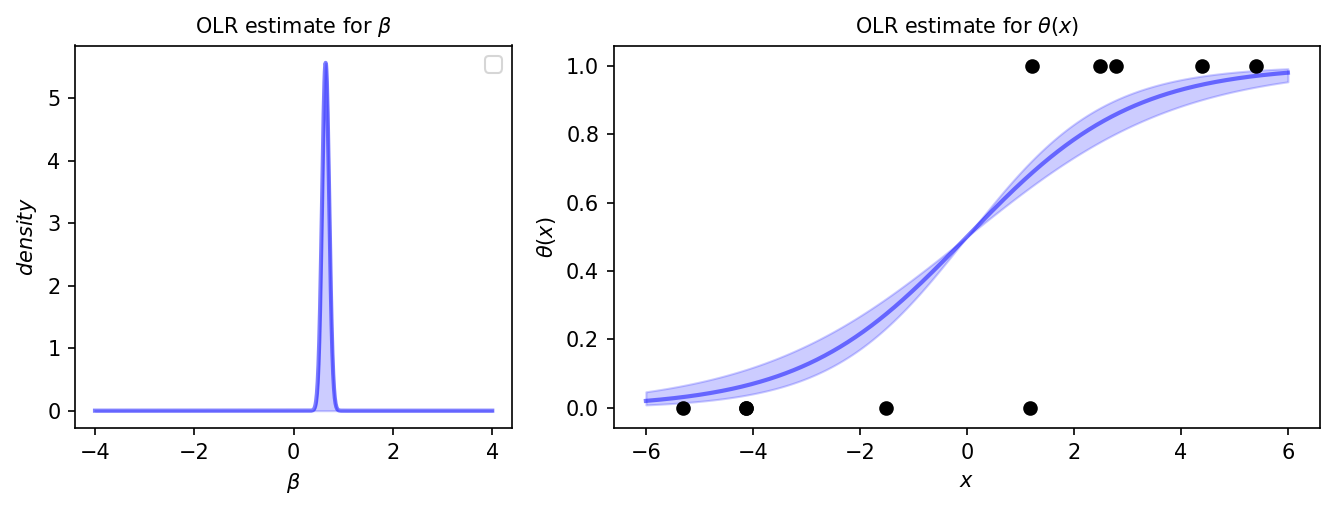

In [ ]:


wee_x = np.random.uniform(-6,6,10)
wee_y = np.array([contextual_categorical_bandit(x,0, theta, noise)[0] for x in wee_x])




# OLR object
online_lr = OnlineLogisticRegression(1, .5, 1)
for i in range(len(wee_y)):
    online_lr.fit(wee_x[i].reshape(-1,1), wee_y[i].reshape(-1,1))
    
    
    
    
    
# closing other figures
plt.close('all')
plt.figure(figsize=[9,3.5], dpi=150)

# let us check the distribution of weights and uncertainty bounds
plt.figure(figsize=[9,3.5], dpi=150)

# plotting the pdf of the weight distribution
X_pdf = np.linspace(-4, 4, 1000)
pdf = stats.norm(loc=online_lr.m, scale=online_lr.q**(-1.0)).pdf(X_pdf)

# range and resolution of probability plot
X_prob = np.linspace(-6, 6, 1000)
p_dist = 1/(1 + np.exp(-X_prob * online_lr.m))
p_dist_plus = 1/(1 + np.exp(-X_prob * (online_lr.m + 2*online_lr.q**(-1.0))))
p_dist_minus = 1/(1 + np.exp(-X_prob * (online_lr.m - 2*online_lr.q**(-1.0))))

# opening subplots
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=3, rowspan=1)

# plotting distriution of weights
ax1.plot(X_pdf, pdf, color='b', linewidth=2, alpha=0.5)
#ax1.plot([cmab.weights[0][1], cmab.weights[0][1]], [0, max(pdf)], 'k--', label='True $\\beta$', linewidth=1)
ax1.fill_between(X_pdf, pdf, 0, color='b', alpha=0.2)

# plotting probabilities
ax2.plot(X_prob, p_dist, color='b', linewidth=2, alpha=0.5)
ax2.fill_between(X_prob, p_dist_plus, p_dist_minus, color='b', alpha=0.2)
ax2.scatter(wee_x, wee_y, c='k')

# title and comments
ax1.set_title('OLR estimate for $\\beta$', fontsize=10)
ax1.set_xlabel('$\\beta$', fontsize=10); ax1.set_ylabel('$density$', fontsize=10)
ax2.set_title('OLR estimate for $\\theta(x)$', fontsize=10)
ax2.set_xlabel('$x$', fontsize=10); ax2.set_ylabel('$\\theta(x)$', fontsize=10)

ax1.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
online_lr.predict_proba(np.array(wee_x[0]))[0]

0.7497864801605931

In [ ]:
wee_x2 = np.random.uniform(-6,6,[10,2])
[x for x in wee_x2]

[array([-2.49426422, -1.60365788]),
 array([-0.52716019,  3.42211154]),
 array([-3.60391461,  0.17081326]),
 array([ 1.10897483, -5.44259505]),
 array([ 1.29053822, -3.95371052]),
 array([-5.21938088,  5.38662645]),
 array([5.5875844 , 3.70076818]),
 array([-2.34463477, -4.82793463]),
 array([ 2.21079632, -0.71817008]),
 array([-4.53554118, -0.05787708])]

In [ ]:
wee_x2 = np.random.uniform(-6,6,[10,2])
wee_y2 = np.array([contextual_categorical_bandit(x,0, theta, noise)[0] for x in wee_x])




# OLR object
online_lr2 = OnlineLogisticRegression(2, .5, 1)
for i in range(len(wee_y2)):
    online_lr2.fit(wee_x2[i].reshape(1,-1), wee_y2[i].reshape(1,-1))
    
online_lr2.predict_proba(wee_x2[0].reshape(1,-1))[0]

array([0.03904842, 0.96095158])

In [ ]:
wee_x2[i].reshape(1,-1).shape

(1, 2)

## numerical
> for regression


### Linear

from https://www.quantstart.com/articles/Bayesian-Linear-Regression-Models-with-PyMC3/

In [ ]:
#export 


class BayesLinReg:

    def __init__(self, n_features, alpha, beta):
        self.n_features = n_features
        self.alpha = alpha
        self.beta = beta
        self.mean = np.zeros(n_features)
        self.cov_inv = np.identity(n_features) / alpha

    def learn(self, x, y):

        # Update the inverse covariance matrix (Bishop eq. 3.51)
        cov_inv = self.cov_inv + self.beta * np.outer(x, x)

        # Update the mean vector (Bishop eq. 3.50)
        cov = np.linalg.inv(cov_inv)
        mean = cov @ (self.cov_inv @ self.mean + self.beta * y * x)

        self.cov_inv = cov_inv
        self.mean = mean

        return self

    def predict(self, x):

        # Obtain the predictive mean (Bishop eq. 3.58)
        y_pred_mean = x @ self.mean

        # Obtain the predictive variance (Bishop eq. 3.59)
        w_cov = np.linalg.inv(self.cov_inv)
        y_pred_var = 1 / self.beta + x @ w_cov @ x.T

        return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)

    @property
    def weights_dist(self):
        cov = np.linalg.inv(self.cov_inv)
        return stats.multivariate_normal(mean=self.mean, cov=cov)


class BatchBayesLinReg(BayesLinReg):

    def learn(self, x, y):

        # If x and y are singletons, then we coerce them to a batch of length 1
        x = np.atleast_2d(x)
        y = np.atleast_1d(y)

        # Update the inverse covariance matrix (Bishop eq. 3.51)
        cov_inv = self.cov_inv + self.beta * x.T @ x

        # Update the mean vector (Bishop eq. 3.50)
        cov = np.linalg.inv(cov_inv)
        mean = cov @ (self.cov_inv @ self.mean + self.beta * y @ x)

        self.cov_inv = cov_inv
        self.mean = mean

        return self

    def predict(self, x):

        x = np.atleast_2d(x)

        # Obtain the predictive mean (Bishop eq. 3.58)
        y_pred_mean = x @ self.mean

        # Obtain the predictive variance (Bishop eq. 3.59)
        w_cov = np.linalg.inv(self.cov_inv)
        y_pred_var = 1 / self.beta + (x @ w_cov * x).sum(axis=1)

        # Drop a dimension from the mean and variance in case x and y were singletons
        # There might be a more elegant way to proceed but this works!
        y_pred_mean = np.squeeze(y_pred_mean)
        y_pred_var = np.squeeze(y_pred_var)

        return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)

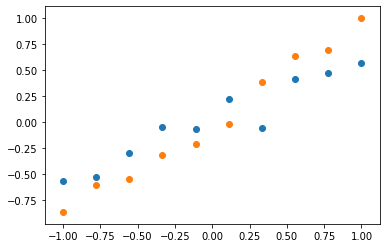

In [ ]:
X = np.linspace(-1,1, 10)
X = np.atleast_2d(X).T
y0 = [contextual_numerical_bandit(x,0,theta,0.1) for x in X]
y1 = [contextual_numerical_bandit(x,1,theta,0.1) for x in X]

plt.scatter(X.squeeze(),y1)
plt.scatter(X.squeeze(),y0)

In [ ]:
np.atleast_2d(X[0]).T == np.atleast_2d(X[0])

array([[ True]])

In [ ]:
X.shape

(10, 1)

In [ ]:
np.atleast_2d(X[0].T).shape

(1, 1)

In [ ]:
bbl = BatchBayesLinReg(n_features = X.shape[1],alpha=0.3, beta=10)

In [ ]:
batch_size = X.shape[0]
n_batches = len(X) // batch_size

batches = zip(
    np.array_split(X, n_batches),
    np.array_split(y0, n_batches)
)

for x_batch, y_batch in batches:
    bbl.learn(np.atleast_2d(x_batch), y_batch)

In [ ]:
y_hat_dist = bbl.predict(X)

In [ ]:
y_hat = y_hat_dist.mean()
y_hat_std = y_hat_dist.std()

In [ ]:
y_hat_std

array([0.35027   , 0.3372321 , 0.32711283, 0.32018902, 0.31667035,
       0.31667035, 0.32018902, 0.32711283, 0.3372321 , 0.35027   ])

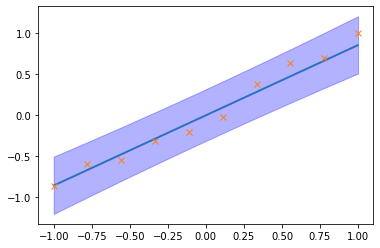

In [ ]:
plt.plot(X.squeeze(),y_hat)
plt.plot(X.squeeze(),y0,'x')
plt.fill_between(X.squeeze(), y_hat, y_hat - y_hat_std, alpha = 0.3,color='blue')
plt.fill_between(X.squeeze(), y_hat, y_hat + y_hat_std, alpha = 0.3,color='blue')


### nonlinear

In [ ]:
#export 
import torch
from torch.autograd import Variable

class SimpleModel(torch.nn.Module):
    def __init__(self,num_input, num_hidden_units=100, p=0.05, decay=0.001, non_linearity=torch.nn.LeakyReLU):
        super(SimpleModel, self).__init__()
        self.dropout_p = p
        self.decay = decay
        self.f = torch.nn.Sequential(
            torch.nn.Linear(num_input,num_hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(num_hidden_units,1)
        )
    def forward(self, X):
        X = Variable(torch.Tensor(X), requires_grad=False)
        return self.f(X)

In [ ]:
X = np.atleast_2d(np.linspace(-3,3,100)).T

y = np.sin(X) + np.random.normal(1)

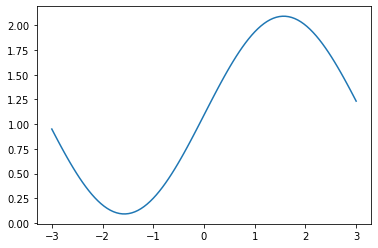

In [ ]:
plt.plot(X,y)

In [ ]:
sm = SimpleModel(1)

In [ ]:
y_hat = sm(X)

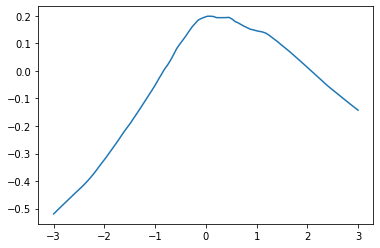

In [ ]:
plt.plot(X,y_hat.detach())

In [ ]:
epochs = 10000

optimizer = torch.optim.SGD(
            sm.parameters(),
            weight_decay=0.01,
            lr=0.001)
criterion = torch.nn.MSELoss()
y = Variable(torch.Tensor(y), requires_grad=False)

for i in range(epochs):
    y_pred = sm(X)
    optimizer.zero_grad()
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

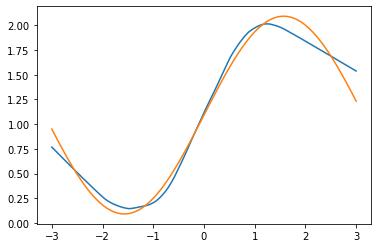

In [ ]:
y_hat = sm(X)
plt.plot(X,y_hat.detach())
plt.plot(X,y)

In [ ]:

from nbdev.export import *
notebook2script()

Converted 00_abstractions.ipynb.
Converted 01_multi_armed_bandits.ipynb.
Converted 02_models.ipynb.
Converted 03_ensembles.ipynb.
Converted 04_solvers.ipynb.
Converted 05_bayesian_regression.ipynb.
Converted 99_helpers.ipynb.
Converted contextual_bandits.ipynb.
Converted index.ipynb.
Converted noncontextual_bandits.ipynb.
Converted nonlinear_bandits.ipynb.
